In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import numpy as np
import scipy
import sys
from PIL import Image
from scipy.stats import spearmanr as spr
import os
import gc
import math
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline

In [3]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient, DeepLift
from captum.attr import visualization as viz

In [4]:
import captum
captum.__version__

'0.4.0'

In [5]:
sys.path.append("../attacks/")
from utils import torch_to_image, load_image,  convert_relu_to_softplus, change_beta_softplus, heatmap_to_image, get_expl
import mister_ed.utils.pytorch_utils as mister_ed_utils

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

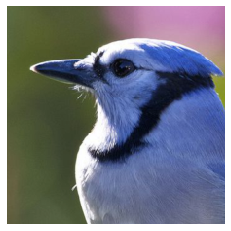

In [7]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0.jpg")
plt.imshow(torch_to_image(x, data_mean, data_std))
plt.axis('off');

In [8]:
sigma = (torch.max(x) - torch.min(x)).item() * 0.2
sigma

0.9447309494018555

In [9]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)

tensor(17, device='cuda:0')


### infidelity and sensitivity


In [14]:
FORWARD_BZ = 50


def forward_batch(model, input, batchsize):
    inputsize = input.shape[0]
    for count in range((inputsize - 1) // batchsize + 1):
        end = min(inputsize, (count + 1) * batchsize)
        if count == 0:
            tempinput = input[count * batchsize:end]
            out = model(tempinput.cuda())
            out = out.data.cpu().numpy()
        else:
            tempinput = input[count * batchsize:end]
            temp = model(tempinput.cuda()).data
            out = np.concatenate([out, temp.cpu().numpy()], axis=0)
    return out

def set_zero_infid(array, size, point, pert):
    if pert == "Gaussian":
        ind = np.random.choice(size, point, replace=False)
        randd = np.random.normal(size=point) * 0.2 + array[ind]
        randd = np.minimum(array[ind], randd)
        randd = np.maximum(array[ind] - 1, randd)
        array[ind] -= randd
        return np.concatenate([array, ind, randd])
    elif pert == "SHAP":
        nz_ind = np.nonzero(array)[0]
        nz_ind = np.arange(array.shape[0])
        num_nz = len(nz_ind)
        bb = 0
        while bb == 0 or bb == num_nz:
            aa = np.random.rand(num_nz)
            bb = np.sum(aa < 0.5)
        sample_ind = np.where(aa < 0.5)
        array[nz_ind[sample_ind]] = 0
        ind = np.zeros(array.shape)
        ind[nz_ind[sample_ind]] = 1
        return np.concatenate([array, ind])
    
def get_exp(ind, exp):
    return (exp[ind.astype(int)])

def get_imageset(image_copy, im_size, rads=[20]):
    rangelist = np.arange(np.prod(im_size)).reshape(im_size)
    width = im_size[1]
    height = im_size[2]
    ind = np.zeros(image_copy.shape)
    count = 0
    for rad in rads:
        for i in range(width - rad + 1):
            for j in range(height - rad + 1):
                ind[count, rangelist[:, i:i+rad, j:j+rad].flatten()] = 1
                image_copy[count, rangelist[:, i:i+rad, j:j+rad].flatten()] = 0
                count += 1
    return image_copy, ind

def nCr(n, r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def shap_kernel(Z, X):
    M = X.shape[0]
    z_ = np.count_nonzero(Z)
    return (M-1) * 1.0 / (z_ * (M - 1 - z_) * nCr(M - 1, z_))

def get_exp_infid(image, model, exp, label, pdt, binary_I, pert):
    point = 3*224*224#784
    total = (np.prod(exp.shape))
    num = 100
    if pert == 'Square':
        im_size = image.shape
        width = im_size[2]
        height = im_size[3]
        rads = np.arange(9, 10) + 1 #np.arange(9, 30)
        num = 0
        for rad in rads:
            num += (width - rad + 1) * (height - rad + 1)
    exp = np.squeeze(exp)
    exp_copy = np.reshape(np.copy(exp), -1)
    image_copy = np.tile(np.reshape(np.copy(image.cpu()), -1), [num, 1])

    if pert == 'Gaussian':
        image_copy_ind = np.apply_along_axis(set_zero_infid, 1, image_copy, total, point, pert)
    elif pert == 'Square':
        image_copy, ind = get_imageset(image_copy, im_size[1:], rads=rads)

    if pert == 'Gaussian' and not binary_I:
        image_copy = image_copy_ind[:, :total]
        ind = image_copy_ind[:, total:total+point]
        rand = image_copy_ind[:, total+point:total+2*point]
        exp_sum = np.sum(rand*np.apply_along_axis(get_exp, 1, ind, exp_copy), axis=1)
        ks = np.ones(num)
    elif pert == 'Square' and binary_I:
        exp_sum = np.array([])
        for i in range(ind.shape[0]//10000 + 1):
            exp_sum = np.concatenate((exp_sum, np.sum(ind[i*10000:(i+1)*10000] * np.expand_dims(exp_copy, 0), axis=1)))
            gc.collect()
#         ks = np.apply_along_axis(shap_kernel, 1, ind, X=image.reshape(-1))
        ks = np.ones(num)
    else:
        raise ValueError("Perturbation type and binary_I do not match.")

#     image_copy = np.reshape(image_copy, (num, 3, 224, 224))
    # divide the following lines in multiple steps to avoid memory overflow
    pdt_rm = np.array([])
    for i in range(image_copy.shape[0]//10000 + 1):
        image_copy_chunk = image_copy[i*10000:(i+1)*10000]
        image_copy_chunk = np.reshape(image_copy_chunk, (-1, 3, 224, 224))
        image_v = Variable(torch.from_numpy(image_copy_chunk.astype(np.float32)).cuda(), requires_grad=False)
        out = forward_batch(model, image_v, FORWARD_BZ)
#         pdt_rm = (out[:, label])
        pdt_rm = np.concatenate((pdt_rm, out[:, label]))
        del image_v
        del image_copy_chunk
        gc.collect()
        torch.cuda.empty_cache()
    pdt_diff = pdt - pdt_rm

    # performs optimal scaling for each explanation before calculating the infidelity score
    beta = np.mean(ks*pdt_diff*exp_sum) / np.mean(ks*exp_sum*exp_sum)
    exp_sum *= beta
    infid = np.mean(ks*np.square(pdt_diff-exp_sum)) / np.mean(ks)
    # free up the memory.
    del image_copy
    gc.collect()
    torch.cuda.empty_cache()
    return infid

def sample_eps_Inf(image, epsilon, N):
    images = np.tile(image, (N, 1, 1, 1))
    dim = images.shape
    return np.random.normal(0, epsilon, size=dim)

def get_exp_sens(X, model, expl, expl_method, y, pdt, sg_r, sg_N, sen_r, sen_N, norm, smooth, binary_I=False):
    max_diff = -math.inf
    for _ in range(sen_N):
        sample = torch.FloatTensor(sample_eps_Inf(X.cpu().numpy(), sen_r, 1)).cuda()
        X_noisy = X + sample
        expl_eps = get_expl(model, X_noisy, expl_method, y, sigma=sg_r,
                                     smooth=smooth, abs_value=False).detach().cpu()
#         expl_eps, _ = get_expl(X_noisy, model, y, expl_method, sg_r=sg_r, sg_N=sg_N, given_expl="Grad", binary_I=binary_I)
        max_diff = max(max_diff, np.linalg.norm(expl-expl_eps)) / norm
    return max_diff

In [11]:
# def get_expl(image, model, label, exp, sg_r=None, sg_N=None, given_expl=None, binary_I=False):
#     image_v = Variable(image, requires_grad=True)
#     model.zero_grad()
#     out = model(image_v)
#     pdtr = out[:, label]
#     pdt = torch.sum(out[:, label])

#     if exp == 'Grad':
#         pdt.backward()
#         grad = image_v.grad
#         expl = grad.data.cpu().numpy()
#         if binary_I:
#             expl = expl * image.cpu().numpy()
#     elif exp == 'Smooth_Grad':
#         avg_points = 50
#         for count in range(int(sg_N/avg_points)):
#             sample = torch.FloatTensor(sample_eps_Inf(image.cpu().numpy(), sg_r, avg_points)).cuda()
#             X_noisy = image.repeat(avg_points, 1, 1, 1) + sample
#             expl_eps, _ = get_expl(X_noisy, model, label, given_expl, binary_I=binary_I)
#             if count == 0:
#                 expl = expl_eps.reshape(avg_points, int(expl_eps.shape[0]/avg_points),
#                                         expl_eps.shape[1], expl_eps.shape[2], expl_eps.shape[3])
#             else:
#                 expl = np.concatenate([expl,
#                                        expl_eps.reshape(avg_points, int(expl_eps.shape[0]/avg_points),
#                                                         expl_eps.shape[1], expl_eps.shape[2], expl_eps.shape[3])],
#                                       axis=0)
#         expl = np.mean(expl, 0)
#     else:
#         raise NotImplementedError('Explanation method not supported.')

#     return expl, pdtr

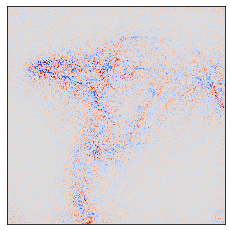

In [12]:
expl = get_expl(model, x, "saliency", desired_index=idx, abs_value=False, smooth=True).detach().cpu()
# expl, _ = get_expl(x, model, idx, "Smooth_Grad", sg_r=sigma, sg_N=50, given_expl="Grad", binary_I=False)
viz.visualize_image_attr(np.transpose(expl.squeeze().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4));

In [13]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [19]:
infds = []
senss = []
# pdt = model(x)[:, idx].detach().cpu().numpy()
for s in range(0, 21, 2):
    print(s)
    expl_smoothgrad = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=s*0.1, abs_value=False).detach().cpu()
#     expl_smoothgrad = normalize_expl(expl_smoothgrad)
    pdt = model(x)[:, idx]
#     expl_smoothgrad, pdt = get_expl(x, model, idx, "Smooth_Grad", sg_r=s*0.1, sg_N=50, given_expl="Grad", binary_I=True)
    norm = np.linalg.norm(expl_smoothgrad)
    infds.append(get_exp_infid(x, model, expl_smoothgrad, idx, pdt.detach().cpu().numpy(), 
                               binary_I=False, pert="Gaussian"))
    senss.append(get_exp_sens(x, model, expl_smoothgrad, "saliency", idx, pdt, sg_r=s*0.1, sg_N=50, sen_r=0.1, sen_N=50, 
                              norm=norm, smooth=True, binary_I=False))


0
2
4
6
8
10
12
14
16
18
20


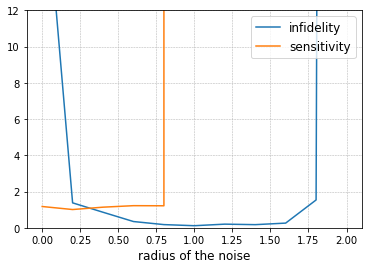

In [20]:
plt.plot(np.arange(21, step=2)*0.1, infds, label="infidelity")
plt.plot(np.arange(21, step=2)*0.1, senss, label="sensitivity");
plt.ylim([0, 12])
plt.legend(fontsize=12)
plt.xlabel("radius of the noise", fontsize=12)
plt.grid(linestyle='--', linewidth=0.5)
# plt.savefig("infidelity_sensitivity_sg_imagenet.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

### softplus

In [14]:
softplus_model = convert_relu_to_softplus(model, beta=10)
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [15]:
beta_values = np.arange(0.0, 10.1, 0.5)
beta_values[0] = 0.1
infds = []
senss = []
for beta in beta_values:
    softplus_model = change_beta_softplus(softplus_model, beta=beta)
    expl, pdt = get_expl(x, softplus_model, idx, "Grad", binary_I=False)
    norm = np.linalg.norm(expl)
#     pdt = model(x)[:, idx]
    infds.append(get_exp_infid(x, softplus_model, expl, idx, pdt.detach().cpu().numpy(), 
                               binary_I=False, pert="Gaussian"))
    senss.append(get_exp_sens(x, softplus_model, expl, "Grad", idx, pdt, sg_r=None, sen_r=0.2, sen_N=10, 
                              norm=norm, smooth=False, binary_I=False))

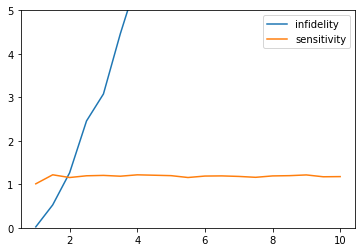

In [16]:
plt.plot(beta_values[2:], infds[2:], label="infidelity")
plt.plot(beta_values[2:], senss[2:], label="sensitivity");
plt.ylim([0, 5])
plt.legend()

In [15]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
def normalize_expl(expl):
    """
    normalize explanation to mean zero and std one
    """
    expl_normalized = expl - expl.mean()
    expl_normalized = expl_normalized / expl.std()
    return expl_normalized

In [14]:
expl_smoothgrad.min()

tensor(-0.0300)

In [16]:
pdt = model(x)[:, idx].detach().cpu().numpy()
get_exp_infid(x, model, normalize_expl(expl), idx, pdt, binary_I=False, pert="Gaussian")

33.08904197853654

In [17]:
norm = np.linalg.norm(normalize_expl(expl))
get_exp_sens(x, model, normalize_expl(expl), "saliency", idx, pdt, sg_r=sigma, sen_r=0.2, sen_N=10, norm=norm, smooth=False)

0.99874187

In [18]:
get_exp_infid(x, model, normalize_expl(expl_smoothgrad), idx, pdt, binary_I=False, pert="Gaussian")

0.07752999199530115

In [19]:
norm = np.linalg.norm(normalize_expl(expl_smoothgrad))
get_exp_sens(x, model, normalize_expl(expl_smoothgrad), "saliency", idx, pdt, sg_r=sigma, sen_r=0.2, sen_N=10, norm=norm, smooth=True)

0.9992315

In [35]:
senss

[1.1549128,
 1.2178293,
 1.009513,
 0.90787625,
 0.8869245,
 0.8933734,
 0.90330434,
 0.93684614,
 7.561753,
 55.888954,
 502.96564,
 3602.6348,
 19911.75,
 69903.41,
 246947.48,
 1124092.8,
 6356670.5,
 15720311.0,
 59809664.0,
 81882220.0,
 198360240.0]

In [14]:
def infidelity_score(X, model, expl, label, device, noise_r=0.2, n_samples=100):
    # replicate the input and explanations n_sample times
    X_samples = np.tile(X.cpu().numpy(), (n_samples, 1, 1, 1))
    expl_samples = np.tile(expl.detach().cpu().numpy(), (n_samples, 1, 1, 1))
    noise = np.random.normal(size=X_samples.shape) * noise_r + X_samples
    noise = np.minimum(X_samples, noise)
    noise = np.maximum(X_samples - 1, noise)
    out_samples = model(X)[:,label]
    out_samples_noisy = model(torch.tensor(X_samples - noise, dtype=torch.float).to(device))[:, label]
    # f(x) - f(x-I)
    diff = out_samples - out_samples_noisy
    # I^t \times \Phi(f,x)
    noise_times_expl = np.sum(np.reshape(noise, (n_samples, -1)) * np.reshape(expl_samples, (n_samples, -1)), axis=1)
    infid = np.mean(np.square(noise_times_expl - diff.data.cpu().numpy()))
    return infid

def sensitivity_score(X, model, expl, label, device, expl_method="saliency", abs_value=True, 
                      smooth=False, sigma=1, sen_r=0.2, sen_N=10):
    max_diff = -1 * np.inf
    norm = np.linalg.norm(expl.detach().cpu().numpy())
    for _ in range(sen_N):
        sample = torch.FloatTensor(np.random.uniform(-1 * sen_r, sen_r, size=X.cpu().numpy().shape)).to(device)
        X_noisy = X + sample
        expl_eps = get_expl(model, X_noisy, expl_method, desired_index=label, abs_value=abs_value,
                            smooth=smooth, sigma=sigma).detach().cpu().numpy()
        max_diff = max(max_diff, np.linalg.norm(expl.detach().cpu().numpy()-expl_eps)) / norm
    return max_diff